In [1]:
!pip install keras-tuner --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.1 MB/s eta 0:00:00


In [18]:
import os
import pandas as pd
import numpy as np
import random
from typing import Dict, Any, Tuple, List, Union

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras_tuner import BayesianOptimization

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import classification_report

import matplotlib.pylab as plt
import seaborn as sns

In [3]:
data = pd.read_csv('/content/Heart_disease_cleveland_new.csv')
data.rename(columns = {'condition':'target'}, inplace = True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


In [4]:
data.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,0,145,233,1,2,150,0,2.3,2,0,2,0
1,67,1,3,160,286,0,2,108,1,1.5,1,3,1,1
2,67,1,3,120,229,0,2,129,1,2.6,1,2,3,1
3,37,1,2,130,250,0,0,187,0,3.5,2,0,1,0
4,41,0,1,130,204,0,2,172,0,1.4,0,0,1,0


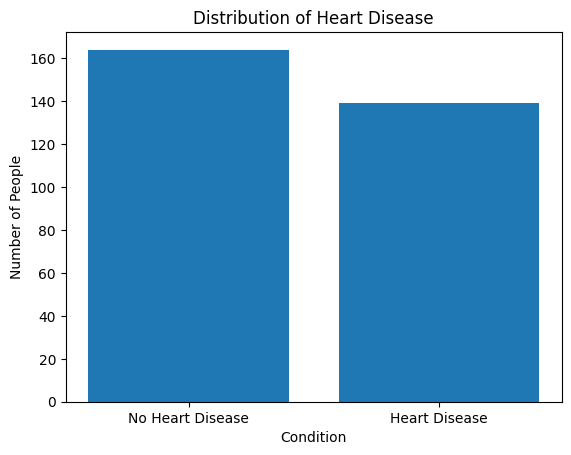

In [5]:
counts = data['target'].value_counts()

plt.bar(['No Heart Disease', 'Heart Disease'], counts.values)
plt.xlabel('Condition')
plt.ylabel('Number of People')
plt.title('Distribution of Heart Disease')
plt.show()

In [6]:
counts

target
0    164
1    139
Name: count, dtype: int64

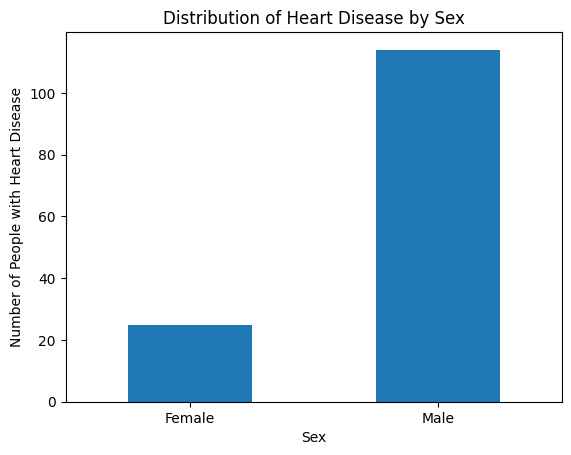

In [7]:
counts = data.groupby(['sex', 'target']).size().unstack()

counts = counts[1]

counts.plot(kind='bar', stacked=True)
plt.xlabel('Sex')
plt.ylabel('Number of People with Heart Disease')
plt.title('Distribution of Heart Disease by Sex')
plt.xticks([0, 1], ['Female', 'Male'], rotation=0)
plt.show()


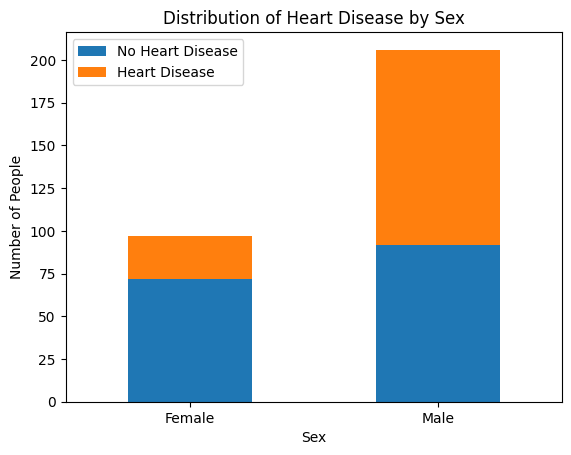

In [8]:
counts = data.groupby(['sex', 'target']).size().unstack()

counts.plot(kind='bar', stacked=True)
plt.xlabel('Sex')
plt.ylabel('Number of People')
plt.title('Distribution of Heart Disease by Sex')
plt.legend(['No Heart Disease', 'Heart Disease'])
plt.xticks([0, 1], ['Female', 'Male'], rotation=0)
plt.show()

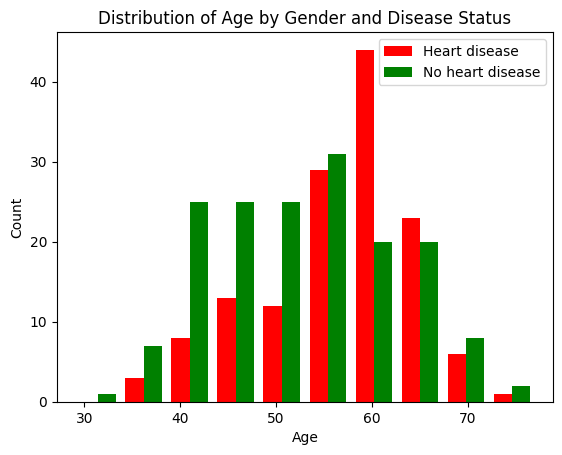

In [9]:
sick = data[data['target'] == 1]
healthy = data[data['target'] == 0]

plt.hist([sick['age'], healthy['age']], bins=10, color=['red', 'green'], label=['Heart disease', 'No heart disease'])
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Distribution of Age by Gender and Disease Status')
plt.legend()
plt.show()

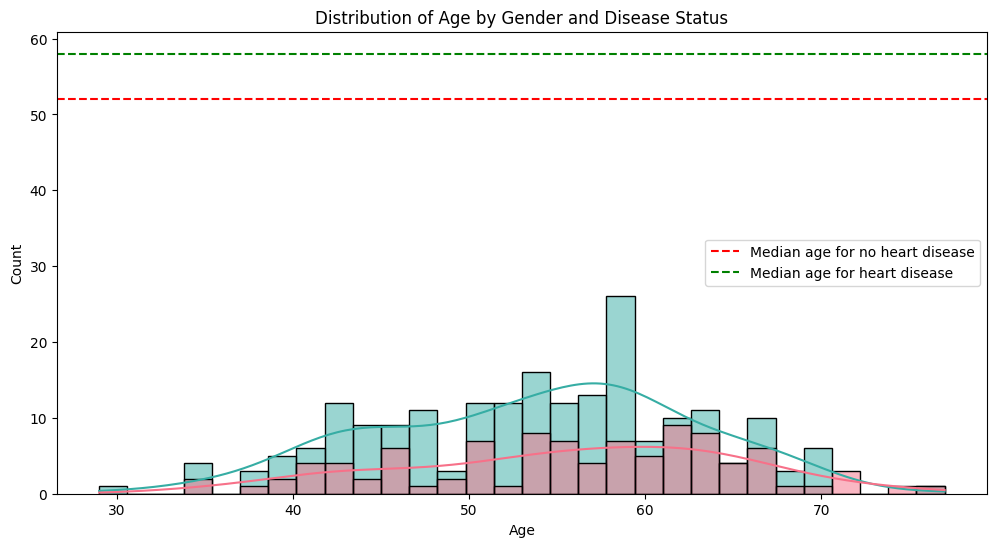

In [10]:
plt.figure(figsize=(12, 6))

sns.histplot(data=data, x='age', hue='sex', kde=True, bins=30, palette='husl')

plt.axhline(y=data[data['target']==0]['age'].median(), color='red', linestyle='--', label='Median age for no heart disease')
plt.axhline(y=data[data['target']==1]['age'].median(), color='green', linestyle='--', label='Median age for heart disease')

plt.legend()
plt.title('Distribution of Age by Gender and Disease Status')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

In [11]:
data.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.438944,0.679868,2.158416,131.689769,246.693069,0.148515,0.990099,149.607261,0.326733,1.039604,0.600660,0.663366,1.831683,0.458746
std,9.038662,0.467299,0.960126,17.599748,51.776918,0.356198,0.994971,22.875003,0.469794,1.161075,0.616226,0.934375,0.956705,0.499120
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,48.000000,0.000000,2.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,56.000000,1.000000,2.000000,130.000000,241.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,1.000000,0.000000
75%,61.000000,1.000000,3.000000,140.000000,275.000000,0.000000,2.000000,166.000000,1.000000,1.600000,1.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,3.000000,3.000000,1.000000


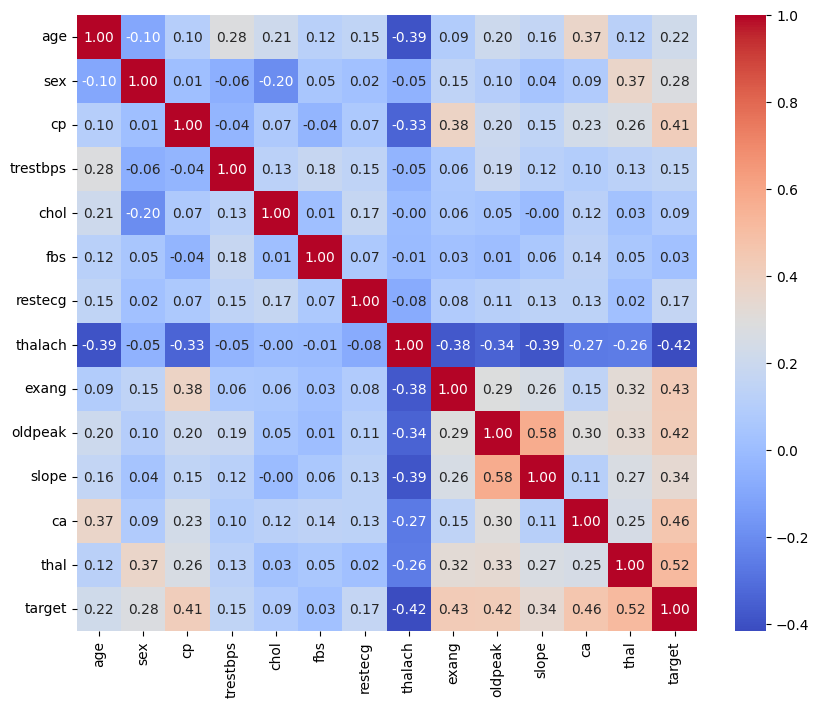

In [12]:
correlation_matrix = data.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.show()

Оптимальна кількість компонент за допомогою PCA: 12


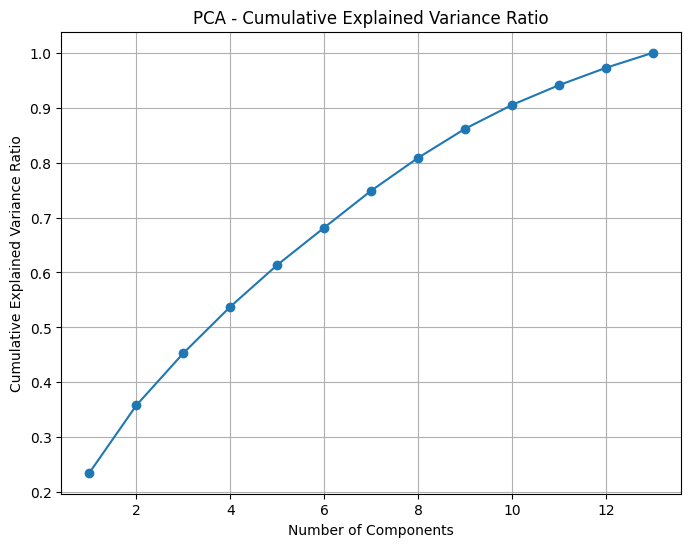

In [17]:
X: pd.DataFrame = data.drop('target', axis=1)
y: pd.DataFrame = data['target']

# Стандартизація ознак
scaler = StandardScaler()
X_scaled: np.ndarray  = scaler.fit_transform(X)

# PCA
pca = PCA()
pca.fit(X_scaled, y)

# Кумулятивна сума дисперсії
cumulative_variance_ratio = np.cumsum(pca.explained_variance_ratio_)

# Знаходження оптимальної кількості компонент
optimal_num_components_pca = np.argmax(cumulative_variance_ratio > 0.95) + 1
print("Оптимальна кількість компонент за допомогою PCA:", optimal_num_components_pca)

plt.figure(figsize=(8, 6))
plt.plot(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio, marker='o', linestyle='-')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('PCA - Cumulative Explained Variance Ratio')
plt.grid(True)
plt.show()


In [26]:
def evaluate_classifiers(X: np.ndarray, y: np.ndarray, param_grids: Dict[str, Tuple[Any, Dict[str, Any]]]) -> pd.DataFrame:
    metrics_data: List[Dict[str, Any]] = []

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    for clf_name, (clf, params) in param_grids.items():
            print(f"Training {clf_name}...")
            grid_search = GridSearchCV(clf, params, cv=10)
            grid_search.fit(X_train, y_train)
            best_params = grid_search.best_params_
            best_estimator = grid_search.best_estimator_

            # Оцінка на тестовому наборі
            y_pred = best_estimator.predict(X_test)
            test_accuracy = accuracy_score(y_test, y_pred)
            train_accuracy = accuracy_score(y_train, best_estimator.predict(X_train))

            # Обчислення метрик
            precision = precision_score(y_test, y_pred)
            recall = recall_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred)
            print(classification_report(y_test, y_pred))
            report_dict = classification_report(y_test, y_pred, target_names=['0', '1'], output_dict=True)

            # Перетворення словника в DataFrame
            report_df = pd.DataFrame(report_dict).transpose()
            report_df.drop('accuracy', axis=0, inplace=True)

            metrics_data.append({'Model': clf_name,
                                 'Best Parameters': best_params,
                                 'Test Accuracy': test_accuracy,
                                 'Train Accuracy': train_accuracy
                                  })

            print(f"Best parameters for {clf_name}: {best_params}")
            print(f"Test accuracy for {clf_name}: {test_accuracy}")
            print("Precision:", precision)
            print("Recall:", recall)
            print("F1-score:", f1)
            print()

            conf_matrix = confusion_matrix(y_test, y_pred)

            plt.figure(figsize=(8, 6))
            sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
            plt.xlabel('Predicted labels')
            plt.ylabel('True labels')
            plt.title('Confusion Matrix')
            plt.show()

    metrics_df = pd.DataFrame(metrics_data)
    return metrics_df

In [27]:
# Параметри для моделей
classifiers: Dict[str, Tuple[Any, Dict[str, Any]]] = {
    "LR": (LogisticRegression(), {'C': [0.001, 0.01, 0.1, 1, 10, 100]}),
    "DT": (DecisionTreeClassifier(), {'max_depth': [None, 10, 20, 30, 40, 50], 'min_samples_split': [2, 5, 10],
                                      'min_samples_leaf': [1, 2, 4]}),
    "RF": (RandomForestClassifier(), {'n_estimators': [100, 200, 300], 'max_depth': [None, 10, 20, 30, 40],
                                      'min_samples_split': [2, 5], 'min_samples_leaf': [1, 2]}),
    "SVM": (SVC(), {'C': [0.001, 0.01, 0.1, 1, 10, 100], 'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
                    'gamma': ['scale', 'auto'], 'degree': [2, 3, 4]}),
    "K-NN": (KNeighborsClassifier(), {'n_neighbors': np.arange(1, 21), 'weights': ['uniform', 'distance'],
                                      'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']})
}

Використаємо PCA для 12 компонент та стандартизуємо дані

Training LR...
              precision    recall  f1-score   support

           0       0.79      0.93      0.86        29
           1       0.93      0.78      0.85        32

    accuracy                           0.85        61
   macro avg       0.86      0.86      0.85        61
weighted avg       0.86      0.85      0.85        61

Best parameters for LR: {'C': 0.01}
Test accuracy for LR: 0.8524590163934426
Precision: 0.9259259259259259
Recall: 0.78125
F1-score: 0.847457627118644



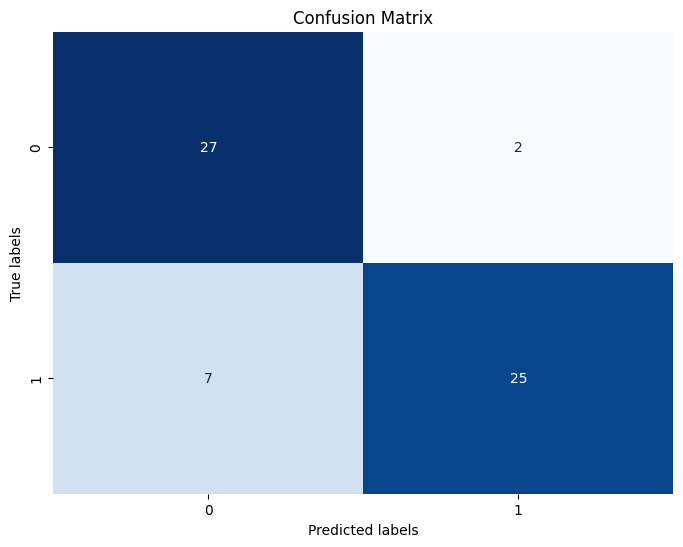

Training DT...
              precision    recall  f1-score   support

           0       0.71      0.93      0.81        29
           1       0.91      0.66      0.76        32

    accuracy                           0.79        61
   macro avg       0.81      0.79      0.78        61
weighted avg       0.82      0.79      0.78        61

Best parameters for DT: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10}
Test accuracy for DT: 0.7868852459016393
Precision: 0.9130434782608695
Recall: 0.65625
F1-score: 0.7636363636363634



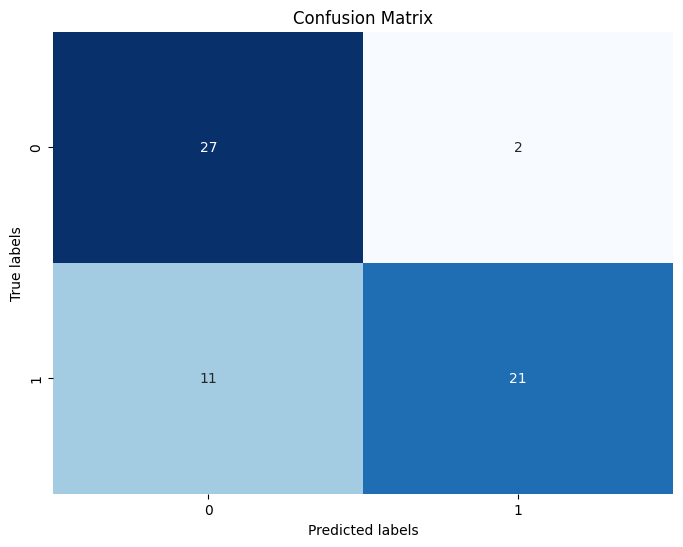

Training RF...
              precision    recall  f1-score   support

           0       0.79      0.90      0.84        29
           1       0.89      0.78      0.83        32

    accuracy                           0.84        61
   macro avg       0.84      0.84      0.84        61
weighted avg       0.84      0.84      0.84        61

Best parameters for RF: {'max_depth': 40, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Test accuracy for RF: 0.8360655737704918
Precision: 0.8928571428571429
Recall: 0.78125
F1-score: 0.8333333333333334



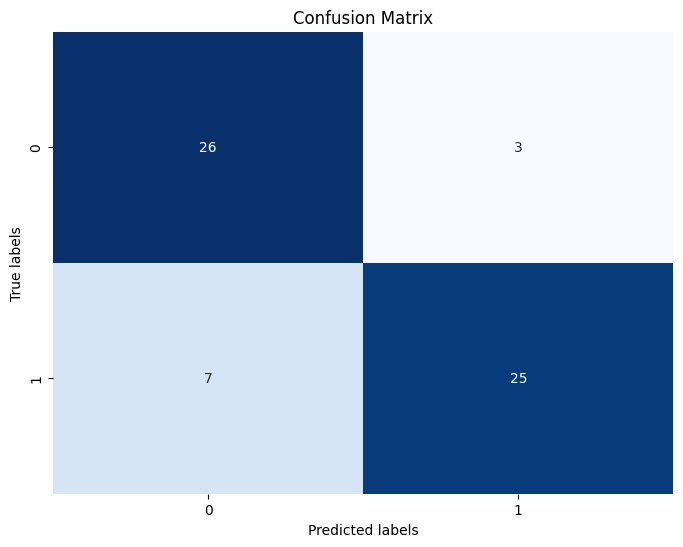

Training SVM...
              precision    recall  f1-score   support

           0       0.87      0.93      0.90        29
           1       0.93      0.88      0.90        32

    accuracy                           0.90        61
   macro avg       0.90      0.90      0.90        61
weighted avg       0.90      0.90      0.90        61

Best parameters for SVM: {'C': 0.1, 'degree': 2, 'gamma': 'scale', 'kernel': 'sigmoid'}
Test accuracy for SVM: 0.9016393442622951
Precision: 0.9333333333333333
Recall: 0.875
F1-score: 0.9032258064516129



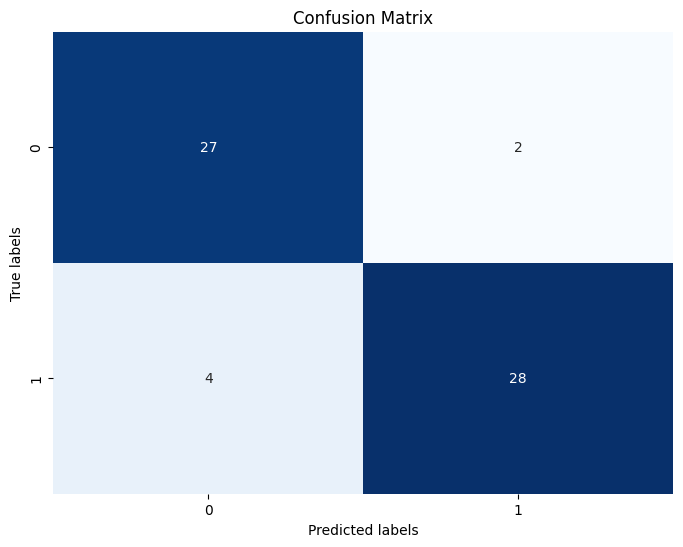

Training K-NN...
              precision    recall  f1-score   support

           0       0.87      0.90      0.88        29
           1       0.90      0.88      0.89        32

    accuracy                           0.89        61
   macro avg       0.88      0.89      0.89        61
weighted avg       0.89      0.89      0.89        61

Best parameters for K-NN: {'algorithm': 'auto', 'n_neighbors': 18, 'weights': 'uniform'}
Test accuracy for K-NN: 0.8852459016393442
Precision: 0.9032258064516129
Recall: 0.875
F1-score: 0.8888888888888888



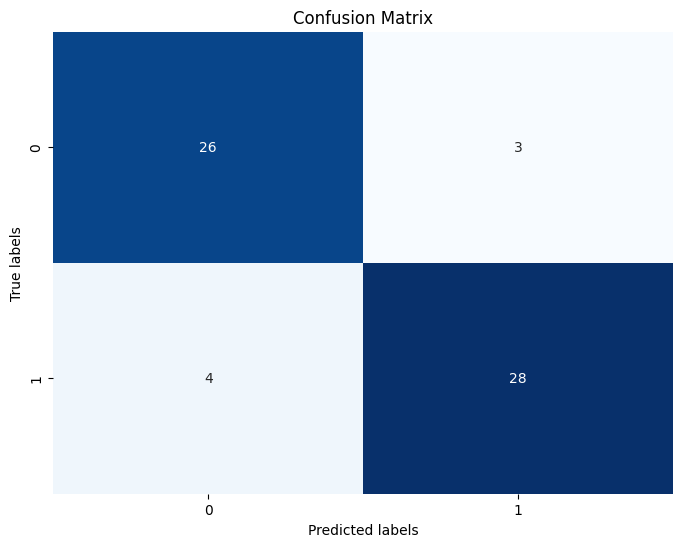

,Model,Best Parameters,Test Accuracy,Train Accuracy
0,LR,{'C': 0.01},0.852459,0.838843
1,DT,"{'max_depth': 10, 'min_samples_leaf': 4, 'min_...",0.786885,0.925620
2,RF,"{'max_depth': 40, 'min_samples_leaf': 2, 'min_...",0.836066,0.995868
3,SVM,"{'C': 0.1, 'degree': 2, 'gamma': 'scale', 'ker...",0.901639,0.834711
4,K-NN,"{'algorithm': 'auto', 'n_neighbors': 18, 'weig...",0.885246,0.822314


In [29]:
n: int = 12

scaler = StandardScaler()
X_scaled: np.ndarray  = scaler.fit_transform(X)

pca = PCA(n_components=n)
X_pca: np.ndarray = pca.fit_transform(X_scaled)
X_pca_df: pd.DataFrame = pd.DataFrame(data=X_pca, columns=[str(f'PCA{i + 1}') for i in range(n)])
X_pca_df["target"] = data["target"]

metrics_df_standard = evaluate_classifiers(X_pca_df.drop('target', axis=1), X_pca_df["target"], classifiers)
metrics_df_standard

12
Training LR...
              precision    recall  f1-score   support

           0       0.79      0.93      0.86        29
           1       0.93      0.78      0.85        32

    accuracy                           0.85        61
   macro avg       0.86      0.86      0.85        61
weighted avg       0.86      0.85      0.85        61

Best parameters for LR: {'C': 0.01}
Test accuracy for LR: 0.8524590163934426
Precision: 0.9259259259259259
Recall: 0.78125
F1-score: 0.847457627118644



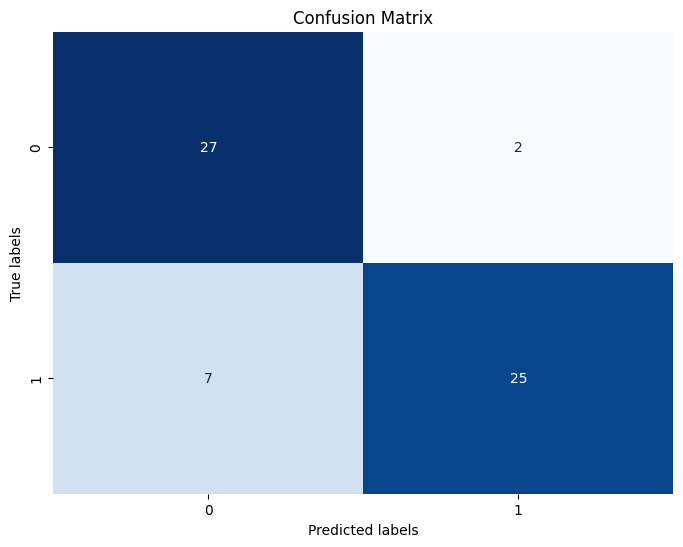

Training DT...
              precision    recall  f1-score   support

           0       0.71      0.93      0.81        29
           1       0.91      0.66      0.76        32

    accuracy                           0.79        61
   macro avg       0.81      0.79      0.78        61
weighted avg       0.82      0.79      0.78        61

Best parameters for DT: {'max_depth': 40, 'min_samples_leaf': 4, 'min_samples_split': 2}
Test accuracy for DT: 0.7868852459016393
Precision: 0.9130434782608695
Recall: 0.65625
F1-score: 0.7636363636363634



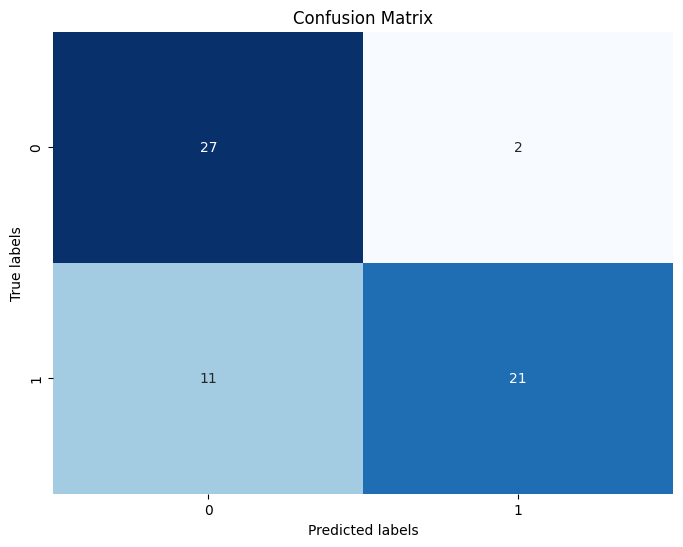

Training RF...
              precision    recall  f1-score   support

           0       0.81      0.90      0.85        29
           1       0.90      0.81      0.85        32

    accuracy                           0.85        61
   macro avg       0.85      0.85      0.85        61
weighted avg       0.86      0.85      0.85        61

Best parameters for RF: {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Test accuracy for RF: 0.8524590163934426
Precision: 0.896551724137931
Recall: 0.8125
F1-score: 0.8524590163934426



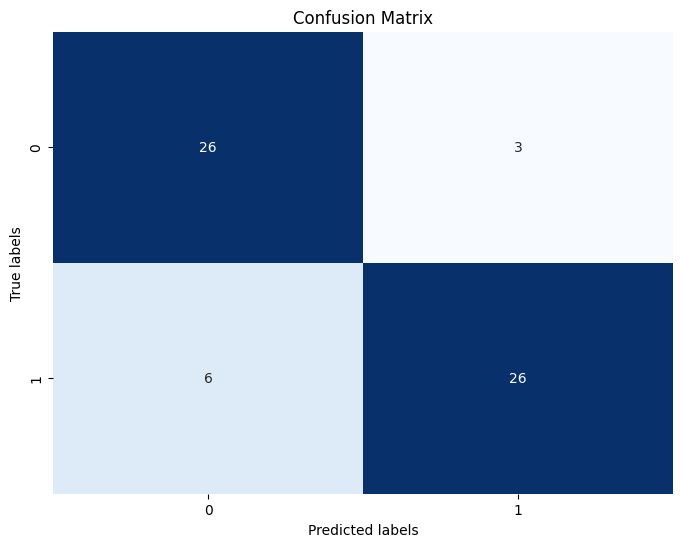

Training SVM...
              precision    recall  f1-score   support

           0       0.87      0.93      0.90        29
           1       0.93      0.88      0.90        32

    accuracy                           0.90        61
   macro avg       0.90      0.90      0.90        61
weighted avg       0.90      0.90      0.90        61

Best parameters for SVM: {'C': 0.1, 'degree': 2, 'gamma': 'scale', 'kernel': 'sigmoid'}
Test accuracy for SVM: 0.9016393442622951
Precision: 0.9333333333333333
Recall: 0.875
F1-score: 0.9032258064516129



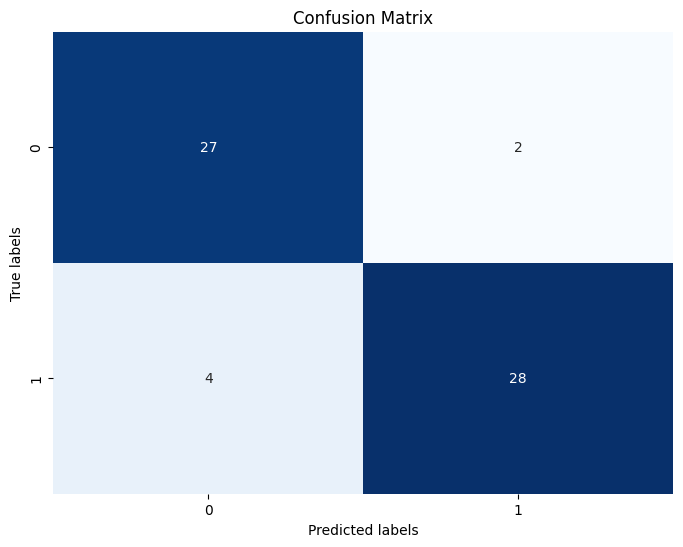

Training K-NN...
              precision    recall  f1-score   support

           0       0.87      0.90      0.88        29
           1       0.90      0.88      0.89        32

    accuracy                           0.89        61
   macro avg       0.88      0.89      0.89        61
weighted avg       0.89      0.89      0.89        61

Best parameters for K-NN: {'algorithm': 'auto', 'n_neighbors': 18, 'weights': 'uniform'}
Test accuracy for K-NN: 0.8852459016393442
Precision: 0.9032258064516129
Recall: 0.875
F1-score: 0.8888888888888888



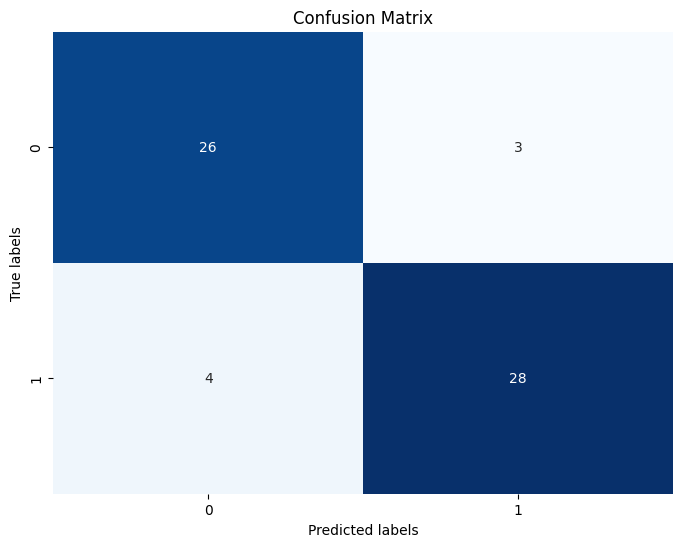

,Model,Best Parameters,Test Accuracy,Train Accuracy
0,LR,{'C': 0.01},0.852459,0.838843
1,DT,"{'max_depth': 40, 'min_samples_leaf': 4, 'min_...",0.786885,0.925620
2,RF,"{'max_depth': 20, 'min_samples_leaf': 2, 'min_...",0.852459,0.983471
3,SVM,"{'C': 0.1, 'degree': 2, 'gamma': 'scale', 'ker...",0.901639,0.834711
4,K-NN,"{'algorithm': 'auto', 'n_neighbors': 18, 'weig...",0.885246,0.822314


In [ ]:
metrics_data = []

for el in [12]:
    n = el
    print(el)
    pca = PCA(n_components=n)
    X_pca = pca.fit_transform(X_scaled)

    X_pca_df = pd.DataFrame(data=X_pca, columns=[str(f'PCA{i + 1}') for i in range(n)])

    X_pca_df["target"] = data["target"]

    X_train, X_test, y_train, y_test = train_test_split(X_pca_df.drop('target', axis=1), X_pca_df["target"], test_size=0.2, random_state=42)

    classifiers = {
        "LR": (LogisticRegression(), {'C': [0.001, 0.01, 0.1, 1, 10, 100]}),
        "DT": (DecisionTreeClassifier(), {'max_depth': [None, 10, 20, 30, 40, 50], 'min_samples_split': [2, 5, 10],
                                          'min_samples_leaf': [1, 2, 4]}),
        "RF": (RandomForestClassifier(), {'n_estimators': [100, 200, 300], 'max_depth': [None, 10, 20, 30, 40],
                                          'min_samples_split': [2, 5], 'min_samples_leaf': [1, 2]}),
        "SVM": (SVC(), {'C': [0.001, 0.01, 0.1, 1, 10, 100], 'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
                        'gamma': ['scale', 'auto'], 'degree': [2, 3, 4]}),
        "K-NN": (KNeighborsClassifier(), {'n_neighbors': np.arange(1, 21), 'weights': ['uniform', 'distance'],
                                          'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']})
    }

    for clf_name, (clf, params) in classifiers.items():
        print(f"Training {clf_name}...")
        grid_search = GridSearchCV(clf, params, cv=10)
        grid_search.fit(X_train, y_train)
        best_params = grid_search.best_params_
        best_estimator = grid_search.best_estimator_

        # Оцінка на тестовому наборі
        y_pred = best_estimator.predict(X_test)
        test_accuracy = accuracy_score(y_test, y_pred)
        train_accuracy = accuracy_score(y_train, best_estimator.predict(X_train))

        # Обчислення метрик
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        print(classification_report(y_test, y_pred))
        report_dict = classification_report(y_test, y_pred, target_names=['0', '1'], output_dict=True)

        # Перетворення словника в DataFrame
        report_df = pd.DataFrame(report_dict).transpose()
        report_df.drop('accuracy', axis=0, inplace=True)

        metrics_data.append({'Model': clf_name,
                             'Best Parameters': best_params,
                             'Test Accuracy': test_accuracy,
                             'Train Accuracy': train_accuracy
                              })

        print(f"Best parameters for {clf_name}: {best_params}")
        print(f"Test accuracy for {clf_name}: {test_accuracy}")
        print("Precision:", precision)
        print("Recall:", recall)
        print("F1-score:", f1)
        print()

        conf_matrix = confusion_matrix(y_test, y_pred)

        plt.figure(figsize=(8, 6))
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
        plt.xlabel('Predicted labels')
        plt.ylabel('True labels')
        plt.title('Confusion Matrix')
        plt.show()

# Створення DataFrame зі списку даних метрик
metrics_df = pd.DataFrame(metrics_data)
metrics_df


Стандартизація даних без використання PCA

Training LR...
              precision    recall  f1-score   support

           0       0.89      0.86      0.88        29
           1       0.88      0.91      0.89        32

    accuracy                           0.89        61
   macro avg       0.89      0.88      0.88        61
weighted avg       0.89      0.89      0.89        61

Best parameters for LR: {'C': 0.1}
Test accuracy for LR: 0.8852459016393442
Precision: 0.8787878787878788
Recall: 0.90625
F1-score: 0.8923076923076922



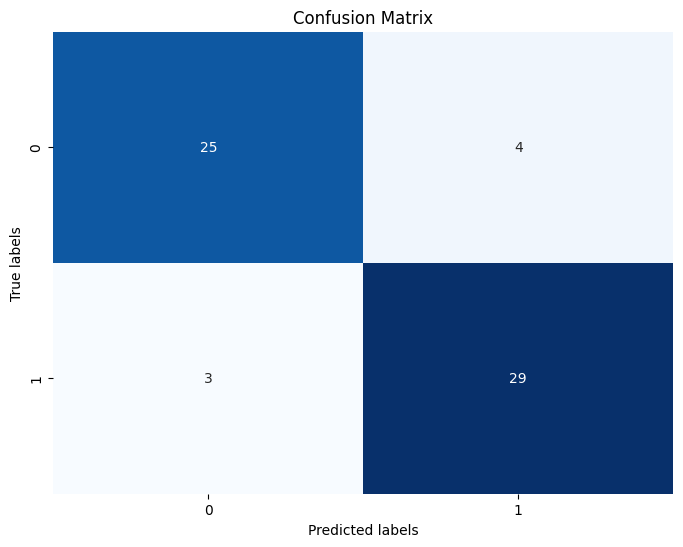

Training DT...
              precision    recall  f1-score   support

           0       0.74      0.86      0.79        29
           1       0.85      0.72      0.78        32

    accuracy                           0.79        61
   macro avg       0.79      0.79      0.79        61
weighted avg       0.80      0.79      0.79        61

Best parameters for DT: {'max_depth': 50, 'min_samples_leaf': 4, 'min_samples_split': 5}
Test accuracy for DT: 0.7868852459016393
Precision: 0.8518518518518519
Recall: 0.71875
F1-score: 0.7796610169491525



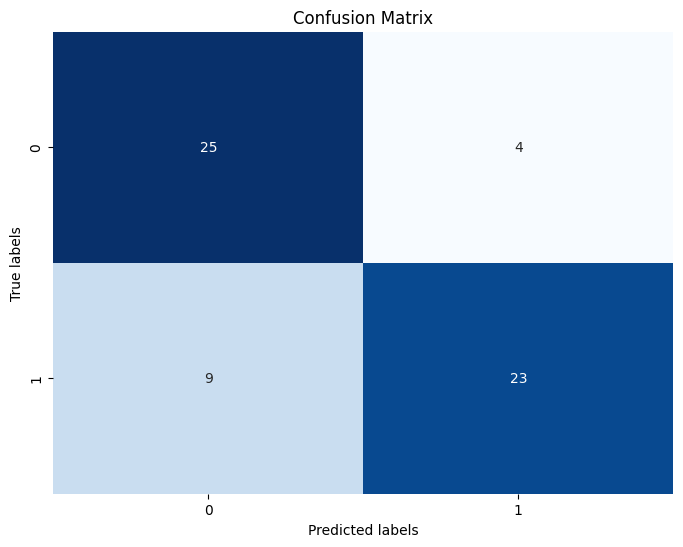

Training RF...
              precision    recall  f1-score   support

           0       0.84      0.93      0.89        29
           1       0.93      0.84      0.89        32

    accuracy                           0.89        61
   macro avg       0.89      0.89      0.89        61
weighted avg       0.89      0.89      0.89        61

Best parameters for RF: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 300}
Test accuracy for RF: 0.8852459016393442
Precision: 0.9310344827586207
Recall: 0.84375
F1-score: 0.8852459016393444



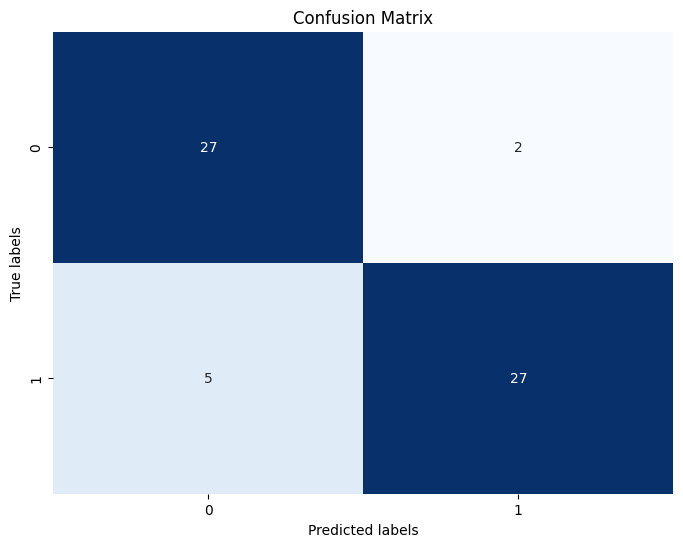

Training SVM...
              precision    recall  f1-score   support

           0       0.87      0.93      0.90        29
           1       0.93      0.88      0.90        32

    accuracy                           0.90        61
   macro avg       0.90      0.90      0.90        61
weighted avg       0.90      0.90      0.90        61

Best parameters for SVM: {'C': 0.1, 'degree': 2, 'gamma': 'scale', 'kernel': 'sigmoid'}
Test accuracy for SVM: 0.9016393442622951
Precision: 0.9333333333333333
Recall: 0.875
F1-score: 0.9032258064516129



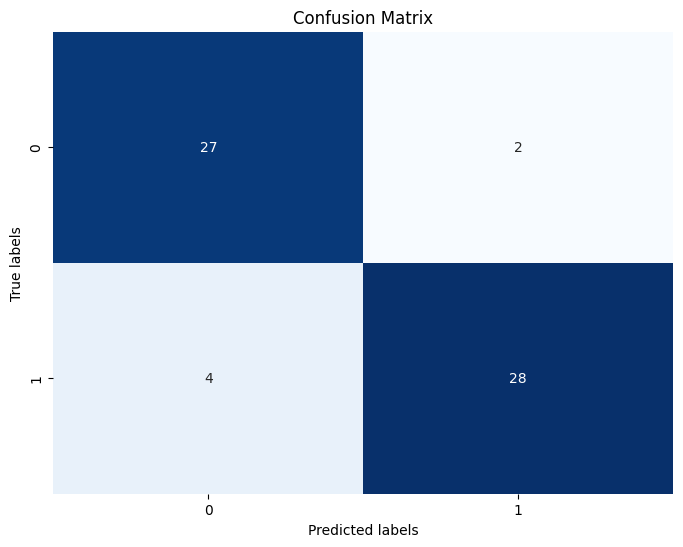

Training K-NN...
              precision    recall  f1-score   support

           0       0.87      0.90      0.88        29
           1       0.90      0.88      0.89        32

    accuracy                           0.89        61
   macro avg       0.88      0.89      0.89        61
weighted avg       0.89      0.89      0.89        61

Best parameters for K-NN: {'algorithm': 'auto', 'n_neighbors': 20, 'weights': 'uniform'}
Test accuracy for K-NN: 0.8852459016393442
Precision: 0.9032258064516129
Recall: 0.875
F1-score: 0.8888888888888888



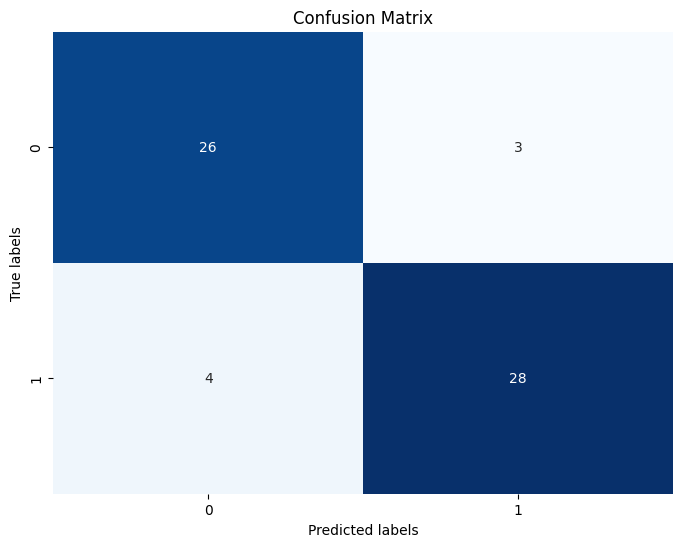

,Model,Best Parameters,Test Accuracy,Train Accuracy
0,LR,{'C': 0.1},0.885246,0.847107
1,DT,"{'max_depth': 50, 'min_samples_leaf': 4, 'min_...",0.786885,0.900826
2,RF,"{'max_depth': None, 'min_samples_leaf': 1, 'mi...",0.885246,0.987603
3,SVM,"{'C': 0.1, 'degree': 2, 'gamma': 'scale', 'ker...",0.901639,0.842975
4,K-NN,"{'algorithm': 'auto', 'n_neighbors': 20, 'weig...",0.885246,0.822314


In [30]:
scaler = StandardScaler()
X_scaled: np.ndarray  = scaler.fit_transform(X)

metrics_df_standard_no_pca = evaluate_classifiers(X_scaled, y, classifiers)
metrics_df_standard_no_pca

Нормалізація min max без використання pca

Training LR...
              precision    recall  f1-score   support

           0       0.89      0.86      0.88        29
           1       0.88      0.91      0.89        32

    accuracy                           0.89        61
   macro avg       0.89      0.88      0.88        61
weighted avg       0.89      0.89      0.89        61

Best parameters for LR: {'C': 10}
Test accuracy for LR: 0.8852459016393442
Precision: 0.8787878787878788
Recall: 0.90625
F1-score: 0.8923076923076922



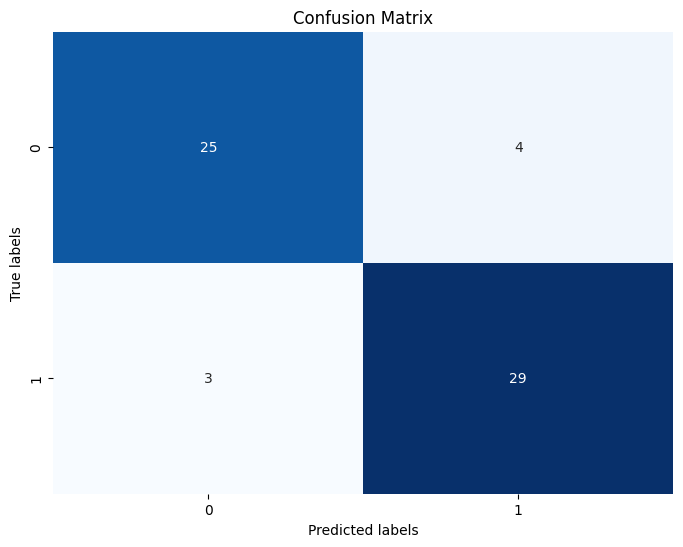

Training DT...
              precision    recall  f1-score   support

           0       0.76      0.86      0.81        29
           1       0.86      0.75      0.80        32

    accuracy                           0.80        61
   macro avg       0.81      0.81      0.80        61
weighted avg       0.81      0.80      0.80        61

Best parameters for DT: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10}
Test accuracy for DT: 0.8032786885245902
Precision: 0.8571428571428571
Recall: 0.75
F1-score: 0.7999999999999999



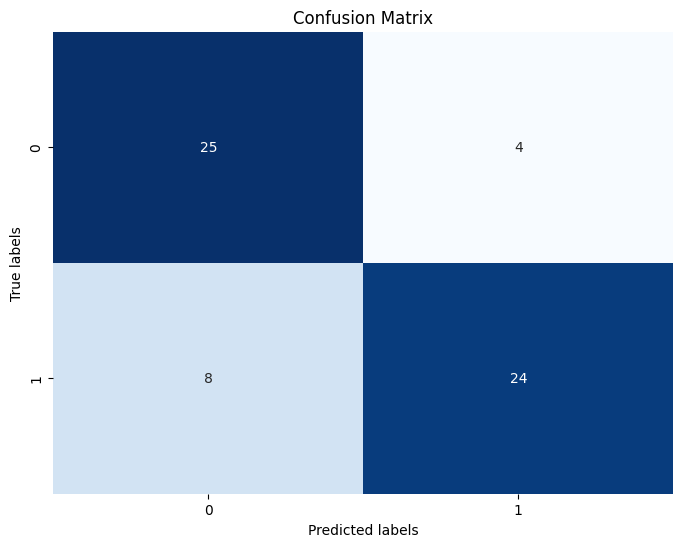

Training RF...
              precision    recall  f1-score   support

           0       0.85      0.97      0.90        29
           1       0.96      0.84      0.90        32

    accuracy                           0.90        61
   macro avg       0.91      0.90      0.90        61
weighted avg       0.91      0.90      0.90        61

Best parameters for RF: {'max_depth': 30, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
Test accuracy for RF: 0.9016393442622951
Precision: 0.9642857142857143
Recall: 0.84375
F1-score: 0.8999999999999999



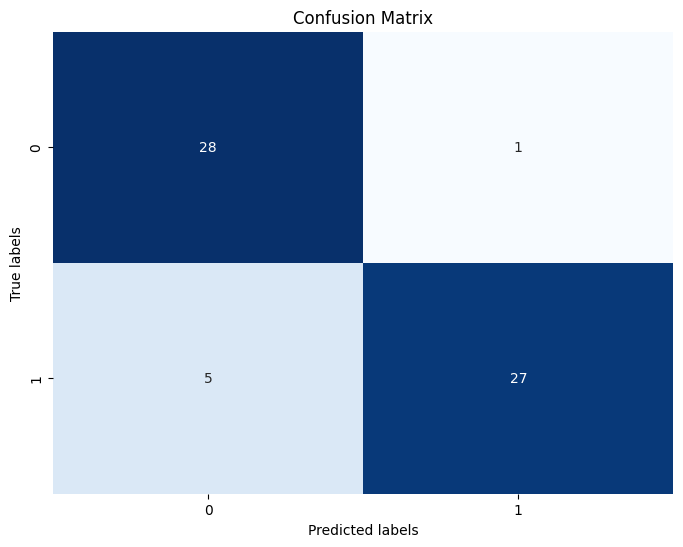

Training SVM...
              precision    recall  f1-score   support

           0       0.78      0.97      0.86        29
           1       0.96      0.75      0.84        32

    accuracy                           0.85        61
   macro avg       0.87      0.86      0.85        61
weighted avg       0.87      0.85      0.85        61

Best parameters for SVM: {'C': 1, 'degree': 2, 'gamma': 'auto', 'kernel': 'poly'}
Test accuracy for SVM: 0.8524590163934426
Precision: 0.96
Recall: 0.75
F1-score: 0.8421052631578947



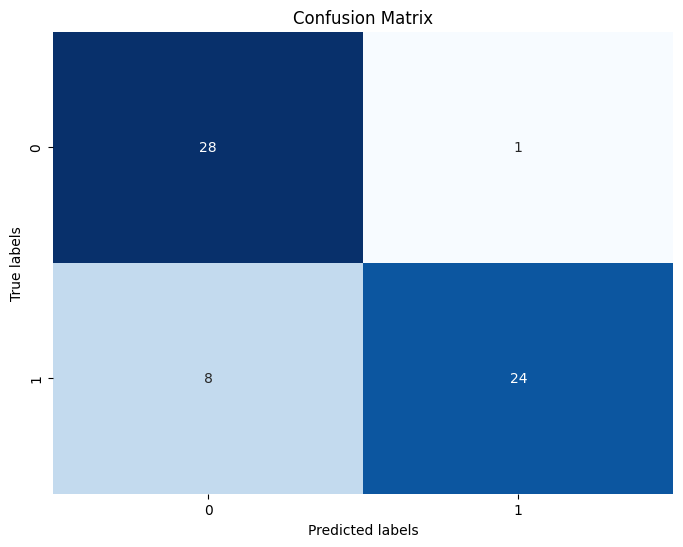

Training K-NN...
              precision    recall  f1-score   support

           0       0.90      0.93      0.92        29
           1       0.94      0.91      0.92        32

    accuracy                           0.92        61
   macro avg       0.92      0.92      0.92        61
weighted avg       0.92      0.92      0.92        61

Best parameters for K-NN: {'algorithm': 'auto', 'n_neighbors': 19, 'weights': 'distance'}
Test accuracy for K-NN: 0.9180327868852459
Precision: 0.9354838709677419
Recall: 0.90625
F1-score: 0.9206349206349206



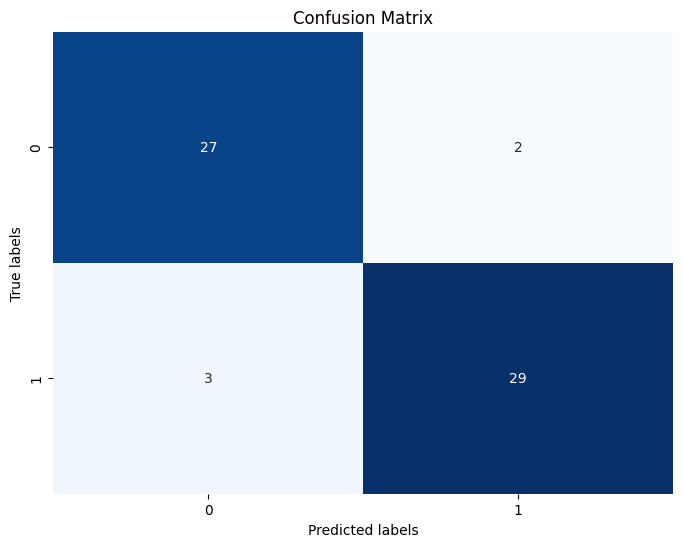

,Model,Best Parameters,Test Accuracy,Train Accuracy
0,LR,{'C': 10},0.885246,0.838843
1,DT,"{'max_depth': 10, 'min_samples_leaf': 4, 'min_...",0.803279,0.896694
2,RF,"{'max_depth': 30, 'min_samples_leaf': 2, 'min_...",0.901639,0.983471
3,SVM,"{'C': 1, 'degree': 2, 'gamma': 'auto', 'kernel...",0.852459,0.834711
4,K-NN,"{'algorithm': 'auto', 'n_neighbors': 19, 'weig...",0.918033,1.000000


In [34]:
scaler = MinMaxScaler()
X_scaled: np.ndarray  = scaler.fit_transform(X)

metrics_df_min_max = evaluate_classifiers(X_scaled, y, classifiers)
metrics_df_min_max

Аналогічні експерименти для DNN

Trial 20 Complete [00h 00m 11s]
val_accuracy: 0.688524583975474

Best val_accuracy So Far: 0.9016393423080444
Total elapsed time: 00h 04m 09s
2/2 [==============================] - 0s 4ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.93      0.92        29
           1       0.94      0.91      0.92        32

    accuracy                           0.92        61
   macro avg       0.92      0.92      0.92        61
weighted avg       0.92      0.92      0.92        61

Confusion Matrix:
[[27  2]
 [ 3 29]]


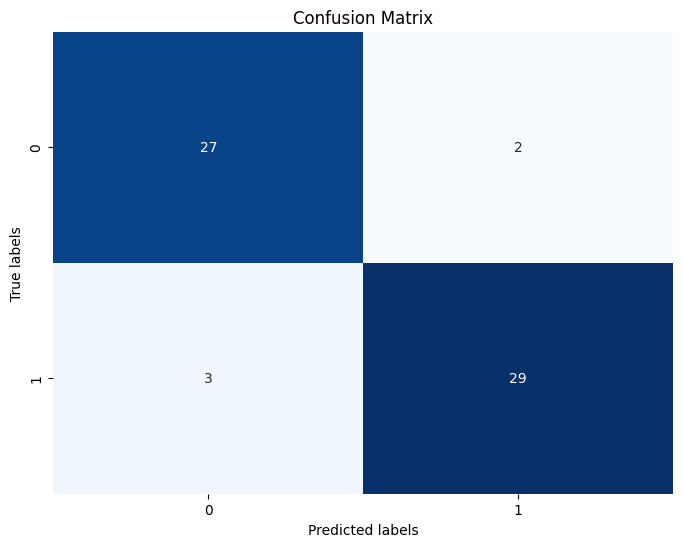

Test accuracy for Dense neural network: 0.9180327653884888
Train accuracy for Dense neural network: 0.913223147392273
Best hyperparameters: <keras_tuner.src.engine.hyperparameters.hyperparameters.HyperParameters object at 0x792adc3ea110>


In [ ]:
def load_data(file_path: str) -> pd.DataFrame:
    """Завантаження даних з CSV файлу."""
    return pd.read_csv(file_path)


def preprocess_data(data: pd.DataFrame, scaler_type: str = 'standard') -> pd.DataFrame:
    """Попередня обробка та підготовка даних."""
    X = data.drop('target', axis=1)
    y = data['target']

    if scaler_type == 'standard':
        scaler = StandardScaler()
    elif scaler_type == 'minmax':
        scaler = MinMaxScaler()
    else:
        raise ValueError("Invalid scaler_type. Please choose 'standard' or 'minmax'.")

    X_scaled = scaler.fit_transform(X)
    return X_scaled, y


def apply_pca(X: np.ndarray, n_components: int) -> pd.DataFrame:
    """Застосування PCA."""
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X)
    return pd.DataFrame(data=X_pca, columns=[f'PCA{i + 1}' for i in range(n_components)])


def split_data(X: pd.DataFrame, y: pd.Series, test_size: float, random_state: int) -> tuple:
    """Розділення даних на навчальний та тестовий набори."""
    return train_test_split(X, y, test_size=test_size, random_state=random_state)


def build_model(hp, input_shape: tuple) -> keras.Sequential:
    """Побудова та налаштування моделі."""
    model = keras.Sequential()
    model.add(layers.Input(shape=input_shape))
    for i in range(hp.Int('num_layers', 1, 5)):
        model.add(layers.Dense(units=hp.Int('units_' + str(i), 64, 256, step=64), activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))

    model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', [1e-1, 1e-2, 1e-3, 1e-4])),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model


def train_model(project_name: str, X_train: pd.DataFrame, y_train: pd.Series, X_test: pd.DataFrame, y_test: pd.Series, epochs: int, batch_size: int) -> tuple:
    """Тренування моделі."""
    input_shape = X_train.shape[1]

    tuner = BayesianOptimization(
        lambda hp: build_model(input_shape=input_shape, hp=hp),
        objective='val_accuracy',
        max_trials=20,
        executions_per_trial=3,
        directory='my_dir',
        project_name=project_name
    )

    tuner.search(X_train, y_train, epochs=epochs, validation_split=0.2, batch_size=batch_size)

    best_model = tuner.get_best_models(num_models=1)[0]
    best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

    test_loss, test_accuracy = best_model.evaluate(X_test, y_test)
    train_loss, train_accuracy = best_model.evaluate(X_train, y_train)
    predictions = (best_model.predict(X_test) > 0.5).astype("int32")

    return test_loss, test_accuracy, train_loss, train_accuracy, predictions, best_model, best_hyperparameters


def evaluate_model(y_test: pd.Series, predictions: np.ndarray) -> tuple:
    """Оцінка моделі."""
    classification_rep = classification_report(y_test, predictions)
    conf_matrix = confusion_matrix(y_test, predictions)
    return classification_rep, conf_matrix

def visualize_results(conf_matrix: np.ndarray) -> None:
    """Візуалізація результатів."""
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()


data = load_data('/content/Heart_disease_cleveland_new.csv')
X, y = preprocess_data(data, scaler_type='standard')

n_components = 12
X_pca_df = apply_pca(X, n_components)

X_train, X_test, y_train, y_test = split_data(X_pca_df, y, test_size=0.2, random_state=42)

test_loss, test_accuracy, train_loss, train_accuracy, predictions, best_model, best_hyperparameters = train_model('heart_disease_classification_pca_std',
    X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, epochs=10, batch_size=16)

classification_rep, conf_matrix = evaluate_model(y_test, predictions)

print("Classification Report:", classification_rep)

visualize_results(conf_matrix)

print("Test accuracy for Dense neural network:", test_accuracy)
print("Train accuracy for Dense neural network:", train_accuracy)
print("Best hyperparameters:", best_hyperparameters)

In [ ]:
# Отримання summary найкращої моделі
best_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                832       
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 64)                4160      
                                                                 
 dense_4 (Dense)             (None, 64)                4160      
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 17537 (68.50 KB)
Trainable params: 17537 (

In [ ]:
print(f"Best hyperparameters: {best_hyperparameters.values}")

Best hyperparameters: {'num_layers': 5, 'units_0': 64, 'learning_rate': 0.01, 'units_1': 64, 'units_2': 64, 'units_3': 64, 'units_4': 64}


Trial 20 Complete [00h 00m 07s]
val_accuracy: 0.5983606576919556

Best val_accuracy So Far: 0.9016393423080444
Total elapsed time: 00h 02m 42s
2/2 [==============================] - 0s 5ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.93      0.92        29
           1       0.94      0.91      0.92        32

    accuracy                           0.92        61
   macro avg       0.92      0.92      0.92        61
weighted avg       0.92      0.92      0.92        61

Confusion Matrix:
[[27  2]
 [ 3 29]]


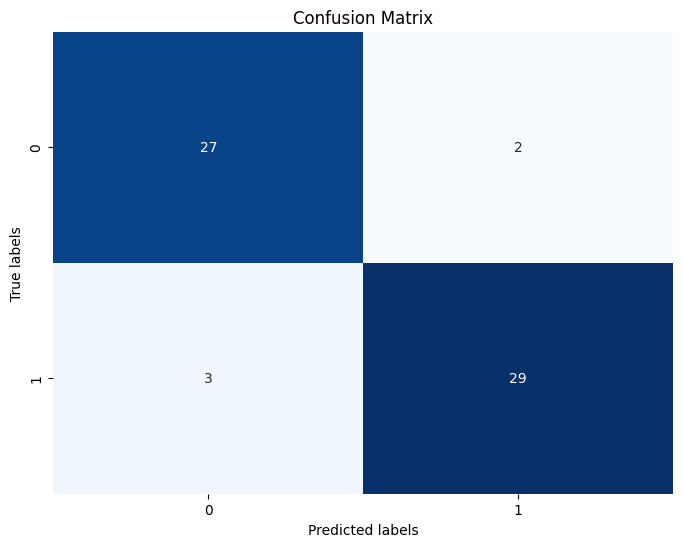

Test accuracy for Dense neural network: 0.9180327653884888
Train accuracy for Dense neural network: 0.8842975497245789
Best hyperparameters: <keras_tuner.src.engine.hyperparameters.hyperparameters.HyperParameters object at 0x792ac6ce7e50>


In [ ]:
X, y = preprocess_data(data, scaler_type='standard')

X_train, X_test, y_train, y_test = split_data(X, y, test_size=0.2, random_state=42)

test_loss, test_accuracy, train_loss, train_accuracy, predictions, best_model, best_hyperparameters = train_model('heart_disease_classification_std',
    X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, epochs=10, batch_size=16)

classification_rep, conf_matrix = evaluate_model(y_test, predictions)

print("Classification Report:", classification_rep)

visualize_results(conf_matrix)

print("Test accuracy for Dense neural network:", test_accuracy)
print("Train accuracy for Dense neural network:", train_accuracy)
print("Best hyperparameters:", best_hyperparameters)

In [ ]:
# Отримання summary найкращої моделі
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                896       
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 9281 (36.25 KB)
Trainable params: 9281 (36.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Trial 18 Complete [00h 00m 08s]
val_accuracy: 0.9098360538482666

Best val_accuracy So Far: 0.9262295067310333
Total elapsed time: 00h 02m 52s
2/2 [==============================] - 0s 5ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.93      0.93        29
           1       0.94      0.94      0.94        32

    accuracy                           0.93        61
   macro avg       0.93      0.93      0.93        61
weighted avg       0.93      0.93      0.93        61

Confusion Matrix:
[[27  2]
 [ 2 30]]


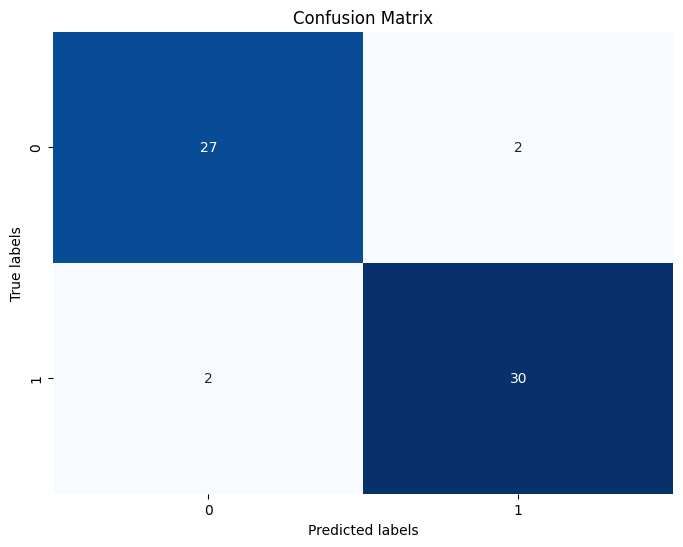

Test accuracy for Dense neural network: 0.9344262480735779
Train accuracy for Dense neural network: 0.8305785059928894
Best hyperparameters: <keras_tuner.src.engine.hyperparameters.hyperparameters.HyperParameters object at 0x792ac4e98b20>


In [ ]:
X, y = preprocess_data(data, scaler_type='minmax')

X_train, X_test, y_train, y_test = split_data(X, y, test_size=0.2, random_state=42)

test_loss, test_accuracy, train_loss, train_accuracy, predictions, best_model, best_hyperparameters = train_model('heart_disease_classification_minmax',
    X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, epochs=10, batch_size=16)

classification_rep, conf_matrix = evaluate_model(y_test, predictions)

print("Classification Report:", classification_rep)

visualize_results(conf_matrix)

print("Test accuracy for Dense neural network:", test_accuracy)
print("Train accuracy for Dense neural network:", train_accuracy)
print("Best hyperparameters:", best_hyperparameters)

In [ ]:
# Отримання summary найкращої моделі
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                896       
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 5121 (20.00 KB)
Trainable params: 5121 (20.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
print(f"Best hyperparameters: {best_hyperparameters.values}")

Best hyperparameters: {'num_layers': 2, 'units_0': 64, 'learning_rate': 0.001, 'units_1': 64, 'units_2': 64, 'units_3': 64, 'units_4': 64}


In [ ]:
X = data.drop('target', axis=1)
y = data['target']

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(13,)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

model.fit(X_train, y_train, epochs=10, batch_size=8)
loss, accuracy = model.evaluate(X_test, y_test)
loss_train, accuracy_train = model.evaluate(X_train, y_train)
print(f'Test loss: {loss}, Test accuracy: {accuracy}')
print(f'Test loss: {loss_train}, Test accuracy: {accuracy_train}')

predictions = (model.predict(X_test) > 0.5).astype("int32")

print("Classification Report:")
print(classification_report(y_test, predictions))

print("Confusion Matrix:")
print(confusion_matrix(y_test, predictions))

Epoch 1/10
31/31 [==============================] - 1s 3ms/step - loss: 0.6537 - accuracy: 0.6736
Epoch 2/10
31/31 [==============================] - 0s 3ms/step - loss: 0.5691 - accuracy: 0.7769
Epoch 3/10
31/31 [==============================] - 0s 4ms/step - loss: 0.4890 - accuracy: 0.7975
Epoch 4/10
31/31 [==============================] - 0s 3ms/step - loss: 0.4326 - accuracy: 0.8140
Epoch 5/10
31/31 [==============================] - 0s 2ms/step - loss: 0.4016 - accuracy: 0.8099
Epoch 6/10
31/31 [==============================] - 0s 3ms/step - loss: 0.3834 - accuracy: 0.8430
Epoch 7/10
31/31 [==============================] - 0s 2ms/step - loss: 0.3735 - accuracy: 0.8264
Epoch 8/10
31/31 [==============================] - 0s 3ms/step - loss: 0.3589 - accuracy: 0.8306
Epoch 9/10
31/31 [==============================] - 0s 3ms/step - loss: 0.3670 - accuracy: 0.8388
Epoch 10/10
8/8 [==============================] - 0s 2ms/step - loss: 0.3370 - accuracy: 0.8554
Test loss: 0.32724806

Confusion Matrix:
[[27  2]
 [ 2 30]]


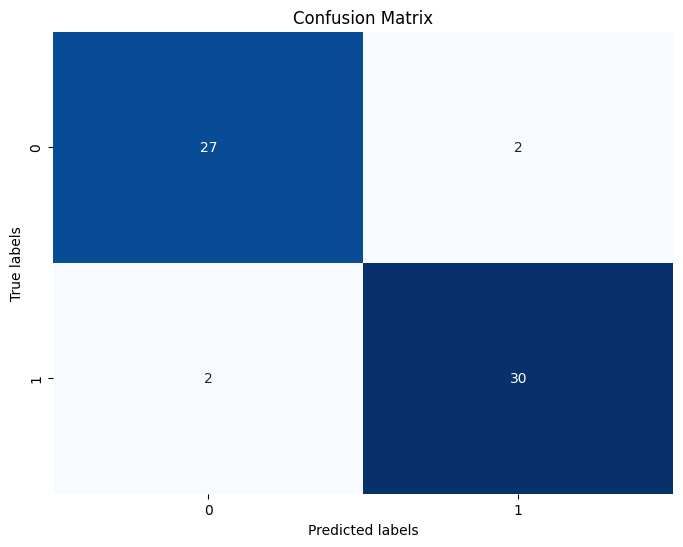

In [ ]:
print("Confusion Matrix:")
print(confusion_matrix(y_test, predictions))

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, predictions), annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
X = data.drop('target', axis=1)
y = data['target']

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(13,)),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

model.fit(X_train, y_train, epochs=10, batch_size=8)
loss, accuracy = model.evaluate(X_test, y_test)
loss_train, accuracy_train = model.evaluate(X_train, y_train)
print(f'Test loss: {loss}, Test accuracy: {accuracy}')
print(f'Test loss: {loss_train}, Test accuracy: {accuracy_train}')

predictions = (model.predict(X_test) > 0.5).astype("int32")

print("Classification Report:")
print(classification_report(y_test, predictions))

print("Confusion Matrix:")
print(confusion_matrix(y_test, predictions))

Epoch 1/10
31/31 [==============================] - 1s 2ms/step - loss: 0.6707 - accuracy: 0.6322
Epoch 2/10
31/31 [==============================] - 0s 2ms/step - loss: 0.6297 - accuracy: 0.7231
Epoch 3/10
31/31 [==============================] - 0s 2ms/step - loss: 0.5942 - accuracy: 0.7893
Epoch 4/10
31/31 [==============================] - 0s 2ms/step - loss: 0.5604 - accuracy: 0.8017
Epoch 5/10
31/31 [==============================] - 0s 2ms/step - loss: 0.5280 - accuracy: 0.8182
Epoch 6/10
31/31 [==============================] - 0s 2ms/step - loss: 0.4977 - accuracy: 0.8182
Epoch 7/10
31/31 [==============================] - 0s 2ms/step - loss: 0.4704 - accuracy: 0.8306
Epoch 8/10
31/31 [==============================] - 0s 2ms/step - loss: 0.4515 - accuracy: 0.8430
Epoch 9/10
31/31 [==============================] - 0s 2ms/step - loss: 0.4336 - accuracy: 0.8306
Epoch 10/10
8/8 [==============================] - 0s 2ms/step - loss: 0.4123 - accuracy: 0.8388
Test loss: 0.34312003

Confusion Matrix:
[[28  1]
 [ 2 30]]


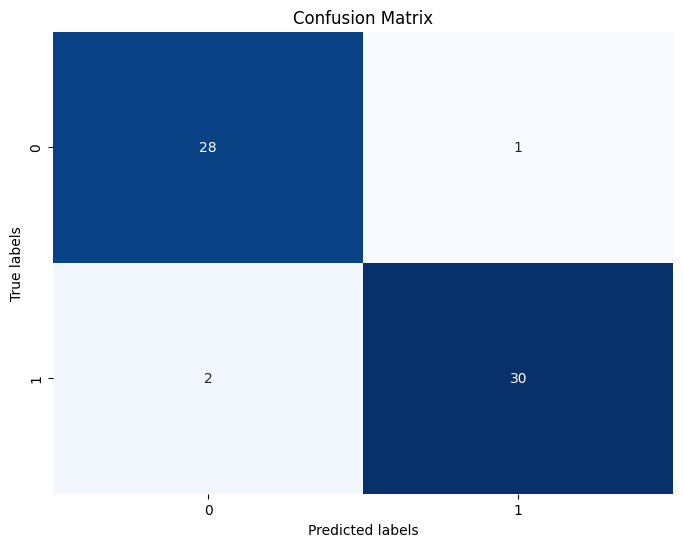

In [ ]:
print("Confusion Matrix:")
print(confusion_matrix(y_test, predictions))

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, predictions), annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
X = data.drop('target', axis=1)
y = data['target']

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(13,)),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

model.fit(X_train, y_train, epochs=10, batch_size=8)
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test loss: {loss}, Test accuracy: {accuracy}')

predictions = (model.predict(X_test) > 0.5).astype("int32")

print("Classification Report:")
print(classification_report(y_test, predictions))

print("Confusion Matrix:")
print(confusion_matrix(y_test, predictions))

Epoch 1/10
31/31 [==============================] - 1s 3ms/step - loss: 0.6659 - accuracy: 0.6570
Epoch 2/10
31/31 [==============================] - 0s 3ms/step - loss: 0.6085 - accuracy: 0.7810
Epoch 3/10
31/31 [==============================] - 0s 3ms/step - loss: 0.5628 - accuracy: 0.7851
Epoch 4/10
31/31 [==============================] - 0s 3ms/step - loss: 0.5271 - accuracy: 0.7934
Epoch 5/10
31/31 [==============================] - 0s 3ms/step - loss: 0.4960 - accuracy: 0.8140
Epoch 6/10
31/31 [==============================] - 0s 3ms/step - loss: 0.4700 - accuracy: 0.8264
Epoch 7/10
31/31 [==============================] - 0s 4ms/step - loss: 0.4516 - accuracy: 0.8306
Epoch 8/10
31/31 [==============================] - 0s 3ms/step - loss: 0.4394 - accuracy: 0.8306
Epoch 9/10
31/31 [==============================] - 0s 5ms/step - loss: 0.4278 - accuracy: 0.8182
Epoch 10/10
2/2 [==============================] - 0s 8ms/step - loss: 0.3478 - accuracy: 0.9508
Test loss: 0.34783273